<a href="https://colab.research.google.com/github/harshithayalla15/FMML/blob/main/FMML_module8Lab_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Machine Learning: Lab 4 - Probabilisitic Mixture Models

Lab by K Ganesh Chandan

kanakala.ganesh@research.iiit.ac.in

In [1]:
!pip install pymc

In [2]:
import os
import json
import re

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import animation as anim
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as pg

import sklearn, sklearn.cluster, sklearn.mixture
import pymc as pm

In [3]:
plt.style.use('ggplot')
np.random.seed(1243451432)
color_map = ['green', 'red', 'purple', 'blue', 'orange']

## Training Probabilistic Models

### Let's some data for Unsupervised Clustering

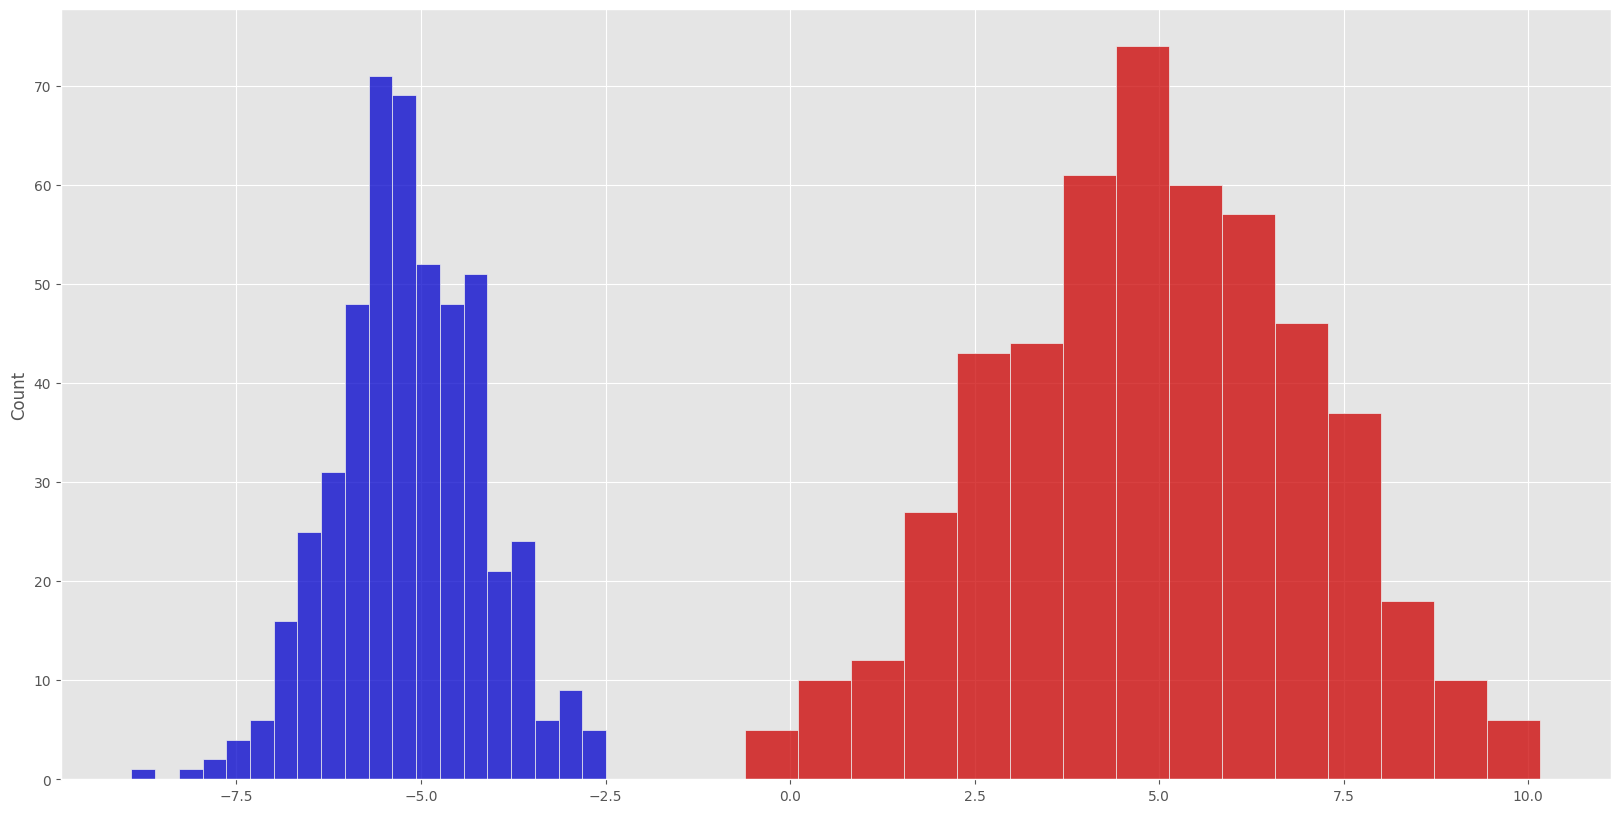

In [4]:
y = np.random.choice([0, 1], p=[0.5, 0.5], size=1000)
true_mu_1 = -5.0
true_mu_2 = 5.0
true_sigma_1 = 1.0
true_sigma_2 = 2.0
X = (y == 0) * np.random.normal(true_mu_1, true_sigma_1, size=len(y)) + (y == 1) * np.random.normal(true_mu_2, true_sigma_2, size=len(y))

fig, ax = plt.subplots(figsize=(20, 10))
sns.histplot(X[y == 0], ax=ax, color='#0000CC')
sns.histplot(X[y == 1], ax=ax, color='#CC0000')
plt.show()

### Expectation Maximization for 2 Classes

[-2.6776427   6.29702435] [4.74036188 6.44260667]
[-2.7780132   3.60550629] [5.04994722 5.6209604 ]
[-2.66950533  2.837141  ] [5.1160104  5.50083961]
[-2.466747   2.4971075] [5.13650168 5.47235704]


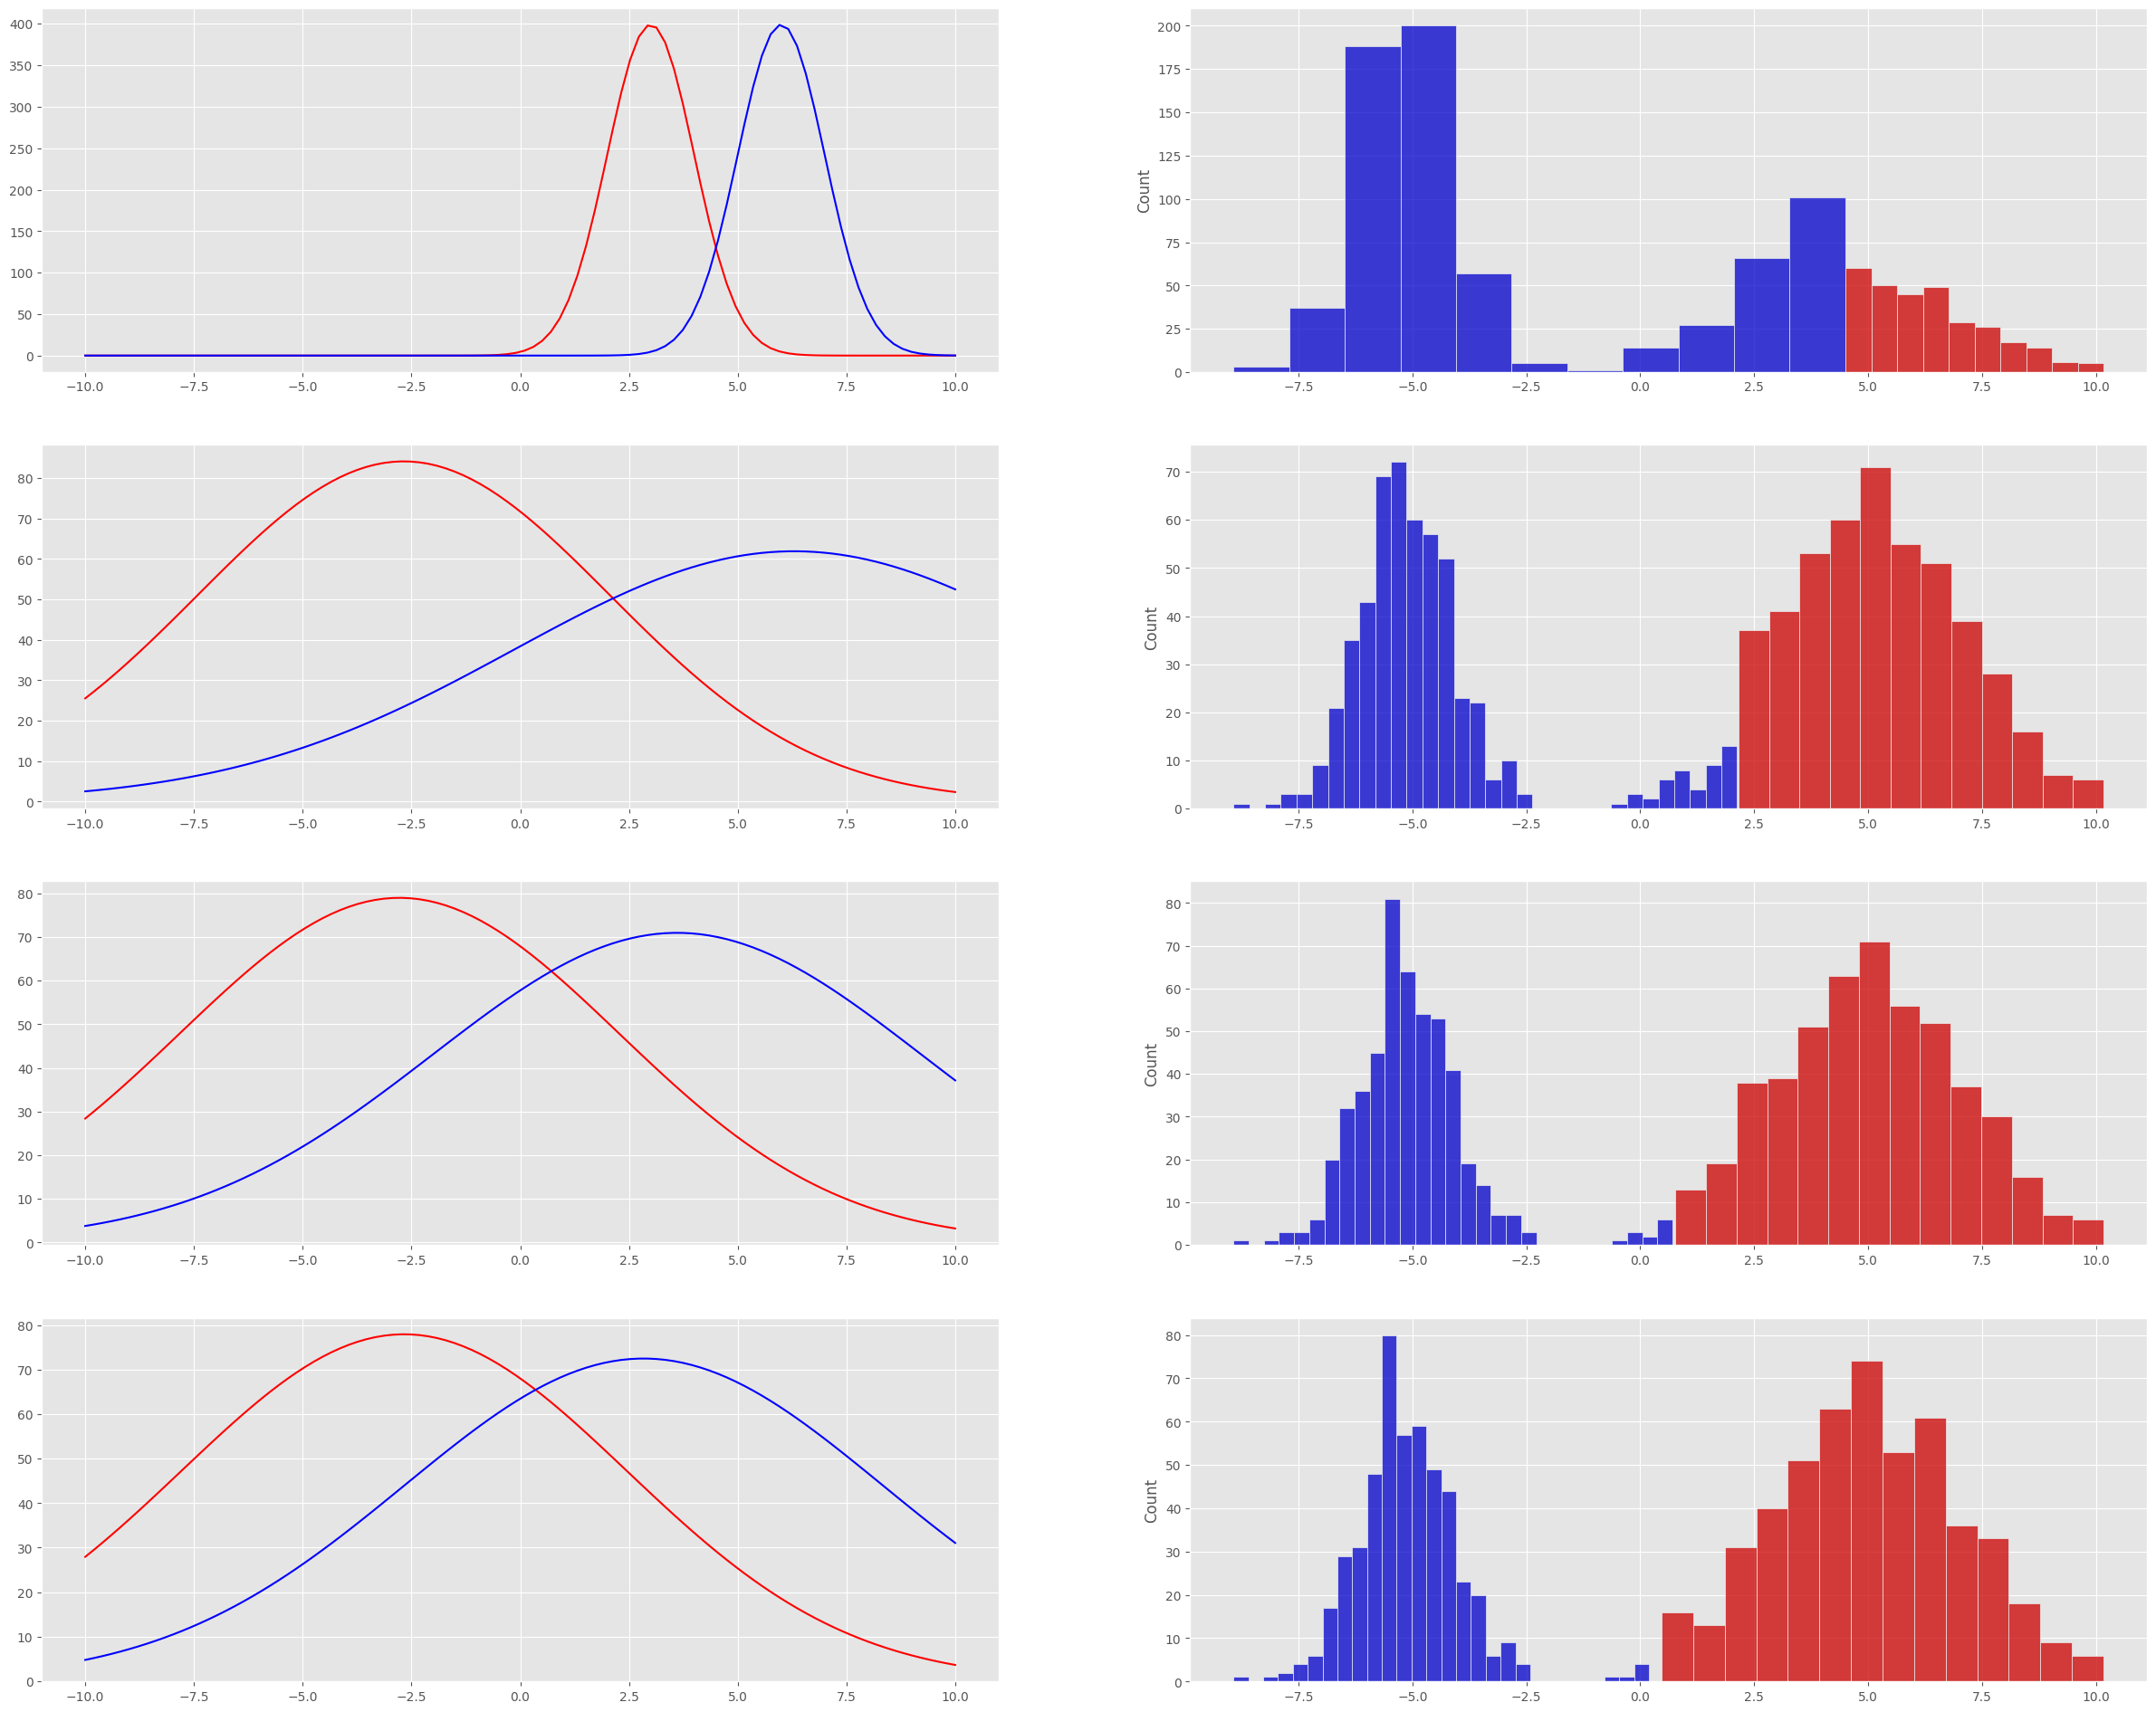

In [5]:
from matplotlib import rc
rc('animation', html='jshtml')

mu, sigma = np.array([3, 6]), np.array([1, 1])
z = np.random.random(size=len(X))
fig, ax = plt.subplots(4, 2, figsize=(15 * 2, 6 * 4))
ax = ax.reshape(-1)

def gaussian(mu, sigma, X):
    return np.exp(-0.5 * ((X - mu) / sigma) ** 2) / (np.sqrt(2 * np.pi) * sigma)

def animate(i):
    global z, mu, sigma, ax
    ax[2 * i].cla()
    domain = np.linspace(-10, 10, 100)
    # Maximization Step
    p0 = gaussian(mu[0], sigma[0], X)
    p1 = gaussian(mu[1], sigma[1], X)
    z = p1 / (p0 + p1)
    ax[2 * i].plot(domain, 1000 * gaussian(mu[0], sigma[0], domain), color='r')
    ax[2 * i].plot(domain, 1000 * gaussian(mu[1], sigma[1], domain), color='b')
    # Plot stuff
    sns.histplot(X[z <= 0.5], ax=ax[2 * i + 1], color='#0000CC')
    sns.histplot(X[z > 0.5], ax=ax[2 * i + 1], color='#CC0000')
    # Expectation Step
    mu = np.array([np.sum((1 - z) * X) / np.sum(1 - z), np.sum(z * X) / np.sum(z)])
    sigma = np.array([np.sqrt(np.sum((1 - z) * X ** 2) / np.sum(1 - z)), np.sqrt(np.sum((z) * X ** 2) / np.sum(z))])
    print(mu, sigma)

for i in range(4):
    animate(i)

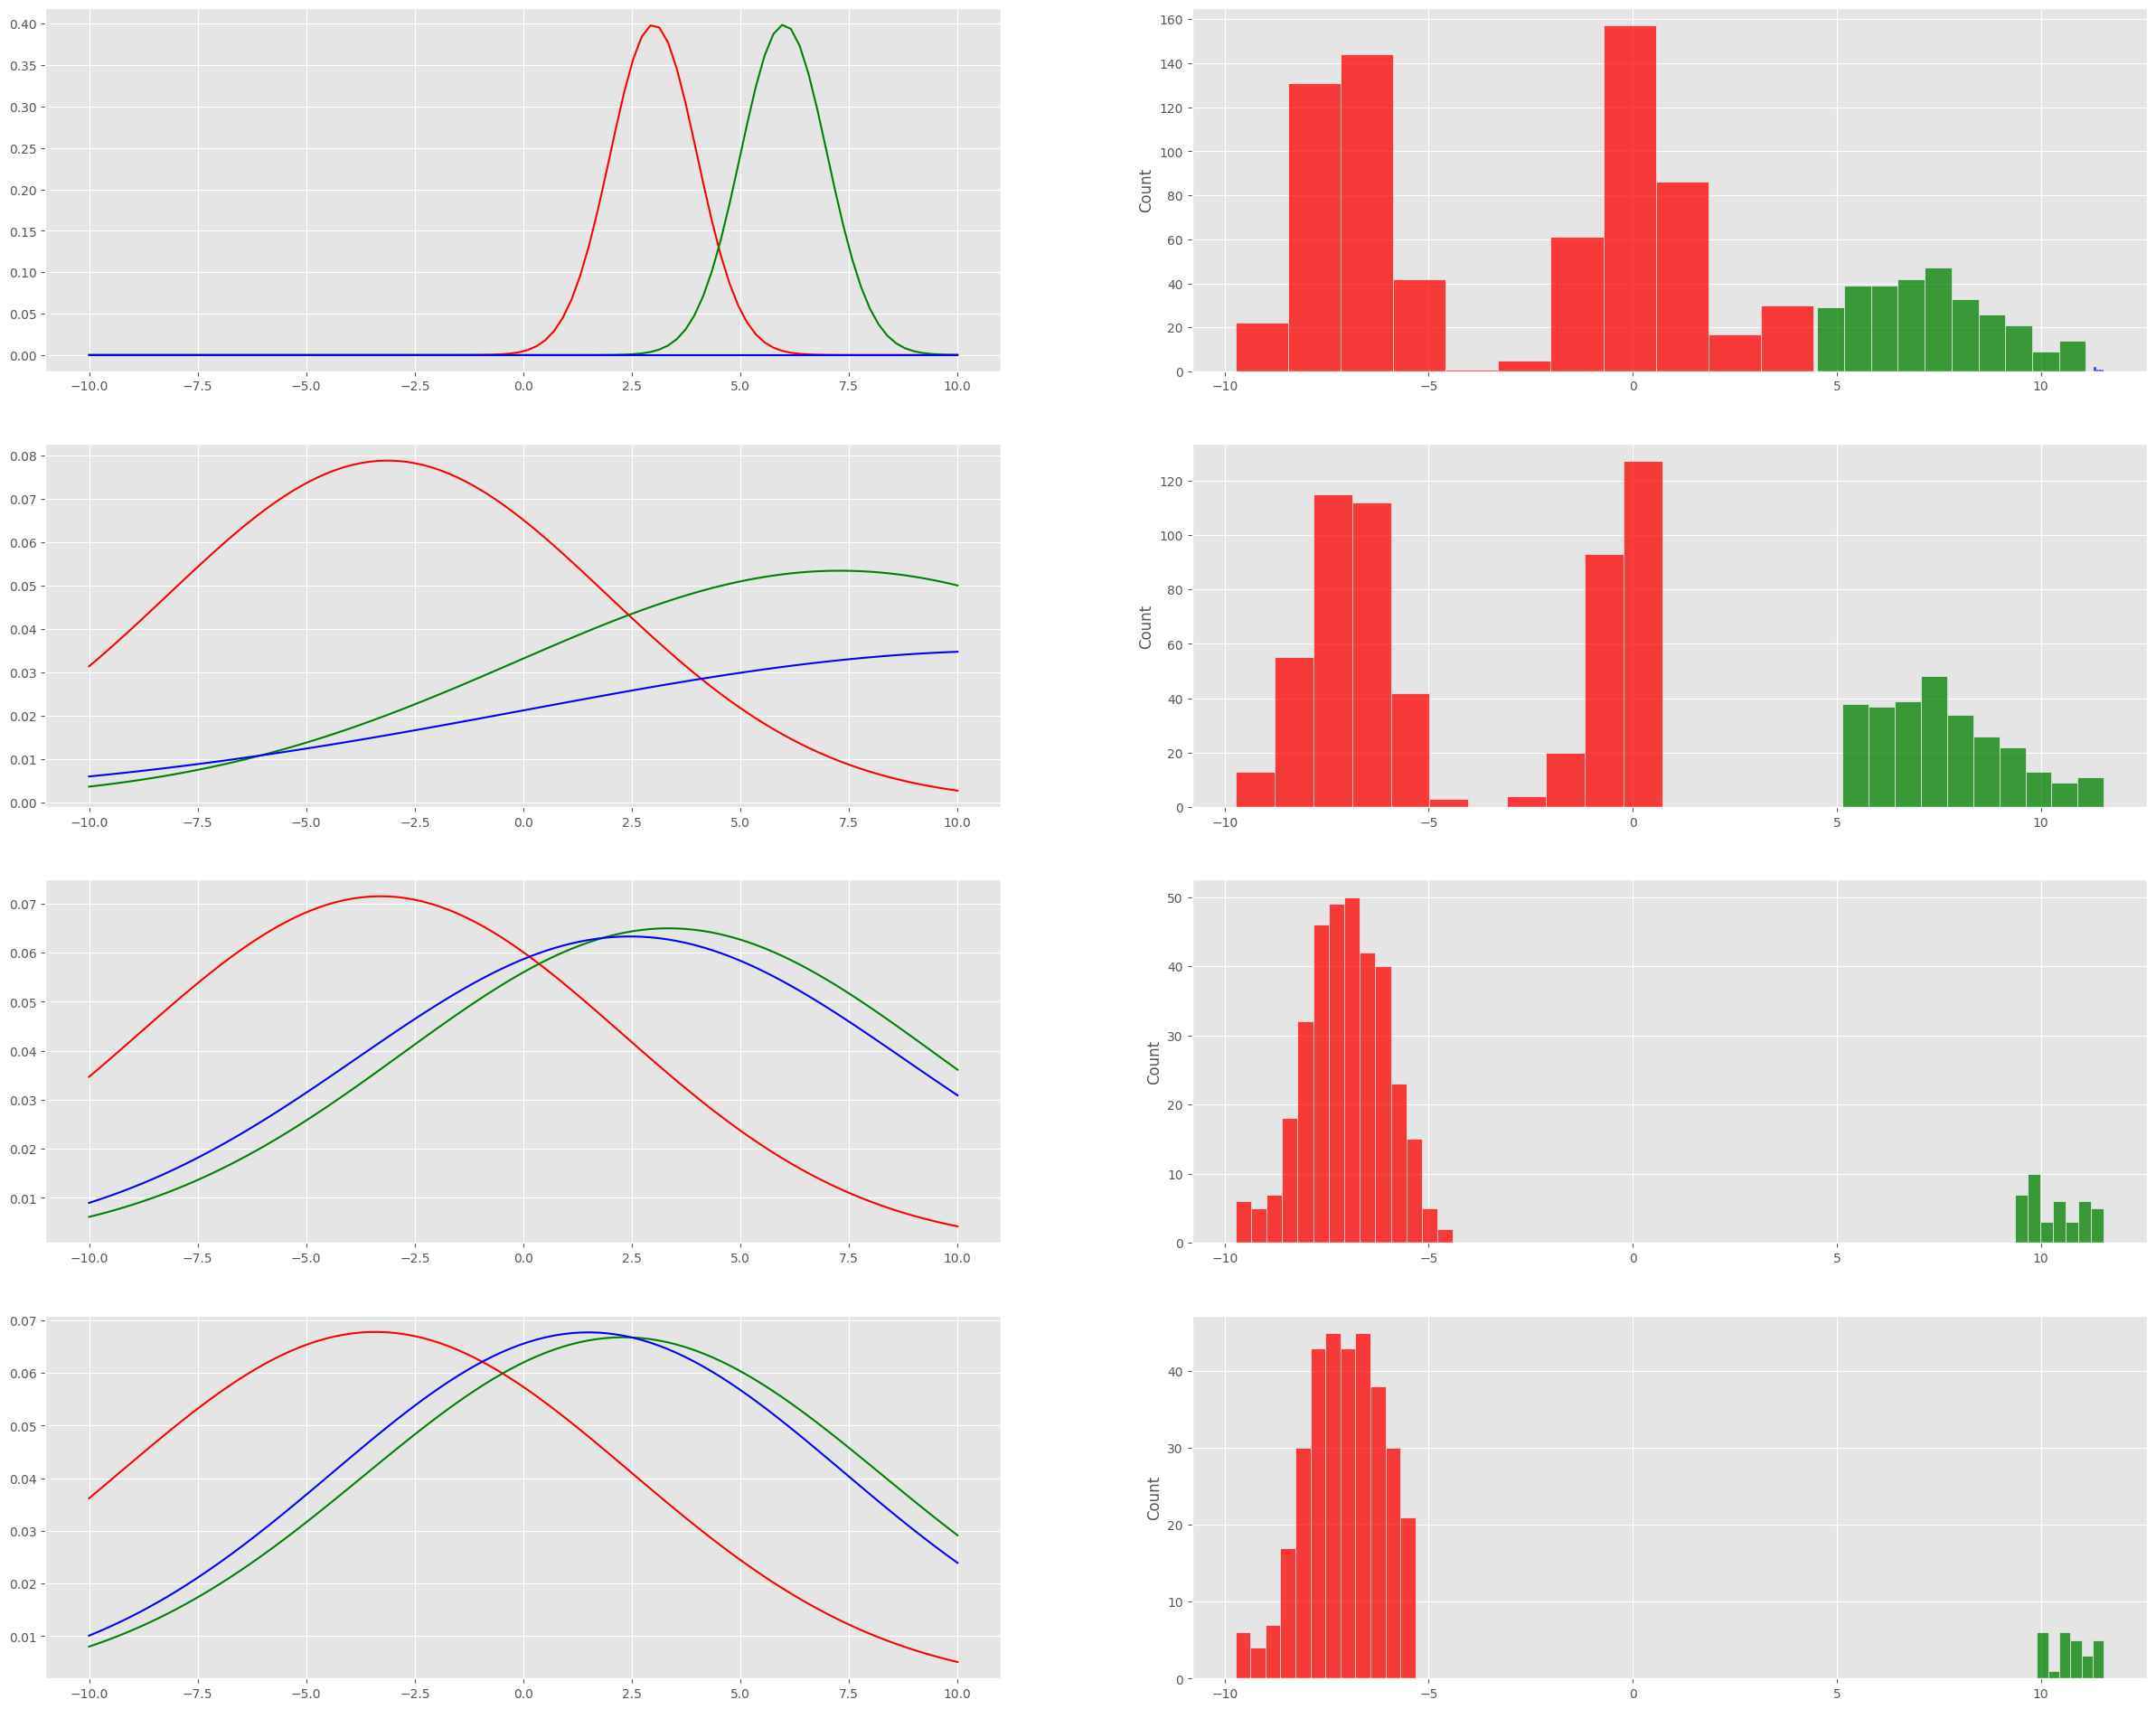

In [6]:
class GaussianMixture:

    def __init__(self, n_clusters, true_mu, true_sigma):
        self.n_clusters = n_clusters
        self.true_mu, self.true_sigma = true_mu, true_sigma
        self.y = np.random.choice(list(range(n_clusters)), p=[1/n_clusters for _ in range(n_clusters)], size=1000)
        self.X = np.sum(np.stack([(self.y == i) * np.random.normal(true_mu[i], true_sigma[i], size=len(y)) for i in range(n_clusters)], axis=0), axis=0)

        self.mu, self.sigma = np.array([3, 6, 15]), np.array([1, 1, 0.7])
        self.z = np.random.random((n_clusters, len(self.y)))
        self.z = self.z / np.reshape(np.sum(self.z, axis=0), (1, -1))
        self.colors = ['r', 'g', 'b', 'k', 'o', 'y'][:n_clusters]

    @staticmethod
    def gaussian(mu, sigma, X):
        return np.exp(-0.5 * ((X - mu) / sigma) ** 2) / (np.sqrt(2 * np.pi) * sigma)

    def expectation(self):
        self.mu = np.array([np.sum(self.z[i] * self.X) / np.sum(self.z[i]) for i in range(self.n_clusters)])
        self.sigma = np.array([np.sqrt(np.sum(self.z[i] * self.X ** 2) / np.sum(self.z[i])) for i in range(self.n_clusters)])

    def maximization(self):
        self.z = np.stack([gaussian(self.mu[i], self.sigma[i], self.X) for i in range(self.n_clusters)], axis=0)
        self.z = self.z / np.reshape(np.sum(self.z, axis=0), (1, -1))

    def plot_full(self, iterations):
        z = np.random.random(size=len(self.X))
        fig, ax = plt.subplots(iterations, 2, figsize=(15 * 2, 6 * iterations))

        if len(ax.shape) == 1:
            ax = ax.reshape(1, ax.shape[0])

        for iter in range(iterations):
            ax[iter][0].cla()
            domain = np.linspace(-10, 10, 100)
            self.maximization()
            for i in range(self.n_clusters):
                ax[iter][0].plot(domain, gaussian(self.mu[i], self.sigma[i], domain), color=self.colors[i])
            for i in range(self.n_clusters):
                sns.histplot(self.X[self.z[i] > 0.5], ax=ax[iter][1], color=self.colors[i])
            self.expectation()

    def plot_truth():
        fig, ax = plt.subplots(figsize=(20, 10))
        for i in range(self.n_clusters):
            sns.histplot(X[y == i], ax=ax, color=self.colors[i])
        plt.show()


gmm = GaussianMixture(3, [-7.0, 0.0, 7.0], [1.0, 1.0, 2.0])
gmm.plot_full(4)

### The real math of Expectation Maximization (Optional)

Remember, that EM algorithm is a **coordinate descent** optimization of variational lower bound $\mathcal{L}(\theta, q) = \int q(T) \log\frac{p(X, T|\theta)}{q(T)}dT\to \max$.

<b>E-step</b>:<br>
$\mathcal{L}(\theta, q) \to \max\limits_{q} \Leftrightarrow \mathcal{KL} [q(T) \,\|\, p(T|X, \theta)] \to \min \limits_{q\in Q} \Rightarrow q(T) = p(T|X, \theta)$<br>
<b>M-step</b>:<br>
$\mathcal{L}(\theta, q) \to \max\limits_{\theta} \Leftrightarrow \mathbb{E}_{q(T)}\log p(X,T | \theta) \to \max\limits_{\theta}$

For GMM, $\theta$ is a set of parameters that consists of mean vectors $\mu_c$, covariance matrices $\Sigma_c$ and priors $\pi_c$ for each component.

Latent variables $T$ are indices of components to which each data point is assigned, i.e. $t_i$  is the cluster index for object $x_i$.

The joint distribution can be written as follows: $\log p(T, X \mid \theta) =  \sum\limits_{i=1}^N \log p(t_i, x_i \mid \theta) = \sum\limits_{i=1}^N \sum\limits_{c=1}^C q(t_i = c) \log \left (\pi_c \, f_{\!\mathcal{N}}(x_i \mid \mu_c, \Sigma_c)\right)$,
where $f_{\!\mathcal{N}}(x \mid \mu_c, \Sigma_c) = \frac{1}{\sqrt{(2\pi)^n|\boldsymbol\Sigma_c|}}
\exp\left(-\frac{1}{2}({x}-{\mu_c})^T{\boldsymbol\Sigma_c}^{-1}({x}-{\mu_c})
\right)$ is the probability density function (pdf) of the normal distribution $\mathcal{N}(x_i \mid \mu_c, \Sigma_c)$.

## Unsupervised Clustering - Gaussian Mixture Model

### Gaussian Mixtures Models in PyMC on 1-D data

First we start by generating some data as a sum of 3 Gaussians, so that we know how to optimally cluster it. The Gaussian Mixture Model will have no idea about the parameters of our model. Nevertheless, visually in our input, we can see the 3 modes in our data, and the data is distributed around these modes. These are what we will call clusters.

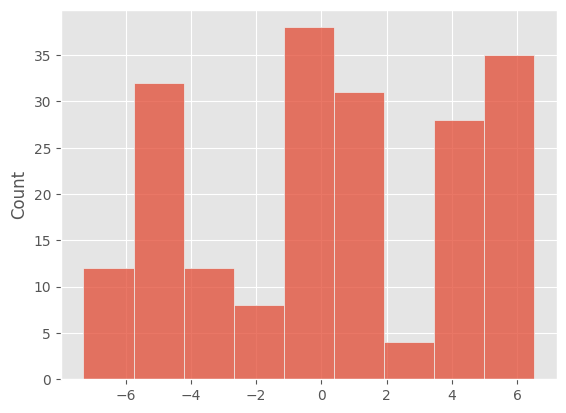

In [7]:
# simulate data from a known mixture distribution
k = 3
ndata = 200
spread = 5
centers = np.array([-spread, 0, spread])

# simulate data from mixture distribution
v = np.random.randint(0, k, ndata)
data = centers[v] + np.random.randn(ndata)

sns.histplot(data);

In [ ]:

# Model setup
with pm.Model() as model:
    p = pm.Dirichlet('p', a=np.ones(k))
    means = pm.Normal('means', mu=np.linspace(-spread, spread, k), sigma=15, shape=k, initval=centers)
    sd = pm.Uniform('sd', lower=0, upper=20)
    obs = pm.NormalMixture('obs', w=p, mu=means, sigma=sd, observed=data)

    # Sampling
    trace = pm.sample(1000, tune=5000, return_inferencedata=True)

In [ ]:
list(p)

In [ ]:
with model:
    pm.plot_trace(trace, var_names=["p", "sd", "means"])

### Recalling what KMeans gave us 2-D data

We have already sesen the use of KMeans clustering, here we will visualize KMeans as a special case of Probabilisitic Clustering.

In [ ]:
size, classes = 100, 4
plt.figure(figsize=(10, 10))
loc = np.array([[23, 25], [80, 61], [74, 13], [33, 82]])
var = np.array([[15, 18], [21, 8], [19, 15], [13, 17]])

X = np.vstack([np.stack([np.random.normal(loc=mean[0], scale=variance[1], size=size),
                         np.random.normal(loc=mean[1], scale=variance[1], size=size)],
                        axis=-1) for mean, variance in zip(loc, var)])
y = np.hstack([np.full(size, fill_value=i) for i in range(classes)])

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=list(map(lambda x: color_map[x], y)), s=10)
    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [np.sqrt(np.sum((X[labels == i] - center) ** 2, axis=1).max()) for i, center in enumerate(centers)]
    for i, (c, r) in enumerate(zip(centers, radii)):
        ax.add_patch(plt.Circle(c, r, fc='gray', lw=3, alpha=0.2, zorder=1))

kmeans = sklearn.cluster.KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

### Applying GMMs to 2-D data

In [ ]:
plt.figure(figsize=(10, 10))
def plot_gmm(gmm, X, n_clusters=4, rseed=0, ax=None):
    labels = gmm.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=list(map(lambda x: color_map[x], y)), s=10)
    # plot the representation of the gmm model
    centers = gmm.means_
    radii = [np.sqrt(np.sum((X[labels == i] - center) ** 2, axis=1).max()) for i, center in enumerate(centers)]
    for i, (c, r) in enumerate(zip(centers, radii)):
        ax.add_patch(plt.Circle(c, r, fc='gray', lw=3, alpha=0.2, zorder=1))

gmm = sklearn.mixture.GaussianMixture(n_components=4, random_state=0)
plot_gmm(gmm, X)

## Topic Modelling - Latent Dirichlet Allocation

### Visualizing a Dirichlet Distribution

In [ ]:
import matplotlib.tri as tri

corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
AREA = 0.5 * 1 * 0.75**0.5
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

# For each corner of the triangle, the pair of other corners
pairs = [corners[np.roll(range(3), -i)[1:]] for i in range(3)]
# The area of the triangle formed by point xy and another pair or points
tri_area = lambda xy, pair: 0.5 * np.linalg.norm(np.cross(*(pair - xy)))

def xy2bc(xy, tol=1.e-4):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    coords = np.array([tri_area(xy, p) for p in pairs]) / AREA
    return np.clip(coords, tol, 1.0 - tol)

class Dirichlet(object):
    def __init__(self, alpha):
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / \
                           np.multiply.reduce([gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * np.multiply.reduce([xx ** (aa - 1)
                                               for (xx, aa)in zip(x, self._alpha)])

def draw_pdf_contours(dist, nlevels=200, subdiv=8, **kwargs):
    import math

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, cmap='jet', **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')

In [ ]:
plt.figure(figsize=(10 * np.sqrt(3) / 2, 10))
x_weight = 7 #@param {type: "slider", min: 0.0, max: 10.0}
y_weight = 4 #@param {type: "slider", min: 0.0, max: 10.0}
z_weight = 7 #@param {type: "slider", min: 0.0, max: 10.0}
draw_pdf_contours(Dirichlet([x_weight, y_weight, z_weight]))

### Loading in the Data

In [ ]:
import nltk
nltk.download("stopwords")
nltk.download("inaugural")
from nltk.corpus import inaugural
from nltk.corpus import stopwords
stops = set(stopwords.words("english"))

In [ ]:
data_dict = {'president': [], 'year': [], 'speech': []}
for fileid in inaugural.fileids():
    speech_string = ""
    for word in inaugural.words(fileid):
        word = word.lower()
        if word not in stops and word.isalpha():
            speech_string += word + ' '
    data_dict["speech"].append(speech_string)
    data_dict["year"].append(fileid[:4])
    data_dict["president"].append(fileid[5:-4])
df = pd.DataFrame(data_dict)
df

### Preprocessing and Vector generation

In [ ]:
from collections import defaultdict

vocab = defaultdict(int)
for idx, speech in enumerate(df["speech"]):
    for word in speech.split():
        vocab[word] += 1
vocab = np.sort(np.array(list(filter(lambda x: vocab[x] > 50, vocab.keys()))))
word_to_index = {word: idx for idx, word in enumerate(vocab)}

print("Constructed Vocabulary of", len(vocab), "words.")

In [ ]:
speech_vectors = np.zeros(shape=(len(df), len(vocab)))
for idx, speech in enumerate(df["speech"]):
    for word in speech.split():
        if word in word_to_index:
            speech_vectors[idx, word_to_index[word]] += 1

print(f"Number of words accounted for: {int(np.sum(speech_vectors))} ({100 * np.sum(speech_vectors) / np.sum(df['speech'].apply(lambda x: len(x.split())))}%)")

plt.figure(figsize=(25, 6))
sns.heatmap(speech_vectors)
plt.show()

### Using SKLearn to try out LDA

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=4, random_state=0)
lda.fit(speech_vectors)
res = lda.transform(speech_vectors)

In [ ]:
for i in range(4):
    print(f"Topic {i+1}:", " ".join([vocab[word] for word in lda.components_[i].argsort()[:5]]))

In [ ]:
df["topic"] = res.argmax(axis=1)
for i in range(4):
    print(f"Presidents on topic {i+1}:", " ".join(df["president"].loc[df["topic"] == i].unique()))
print()
df["topic"] = res.argmax(axis=1)
for i in range(4):
    print(f"Years on topic {i+1}:", " ".join(df["year"].loc[df["topic"] == i].unique()))

### Implementating Latent Dirichlet Allocation (Optional)

**The specific code for LDA is not needed, and is available as a library function in SKLearn. Code sample for the same is provided in the following section**

In [ ]:
class LatentDirichletAllocation:

    def __init__(self, data, topics=10):
        """
        Takes the data variable and outputs a model
        """
        self.data = data
        self.num_topics, self.num_vocab, self.num_docs = self.data.shape[1] + 1, self.data.shape[0], topics
        self.alpha, self.beta = np.ones(self.num_topics), np.ones(self.num_vocab)
        with pm.Model() as model:
            self.theta = pm.Dirichlet("thetas", a=self.alpha, shape=(self.docs, self.vocab))
            self.phi = pm.Dirichlet("phis", a=self.beta, shape=(K, V))
            self.z = pm.Categorical("zx", p=thetas, shape=(W, D))
            self.w = pm.Categorical("wx", p=t.reshape(phis[z], (D*W, V)), observed=data.reshape(D*W))
        self.model = pm.Model([self.theta, self.phi, self.z, self.w])
        self.mcmc = pm.MCMC(self.model)

    def fit(self, iterations=1000, burn_in=10):
        self.mcmc.sample(iterations, burn=burn_in)

    @property
    def topics(self):
        return self.phi.value

    @property
    def words(self):
        return self.W.value

    @staticmethod
    def kl_divergence(p, q):
        return np.sum(p*np.log10(p/q))

    @staticmethod
    def cosine_similarity(x, y):
        return np.dot(x,y) / np.sqrt(np.dot(x,x) * np.dot(y,y))

    def sorted_docs_sim(self):
        kldivs_docs = [(i, j, self.kl_divergence(self.theta[i].value,self.theta[j].value),
                        self.cosine_similarity(self.data[i], self.data[j]))
                       for i in range(len(self.theta)) for j in range(len(self.theta))
                       if i != j]
        return sorted(kldivs_docs, key=lambda x: x[3], reverse=True)

    def show_topic_words(self, idwords, n=10):
        for i, t in enumerate(self.phi.value):
            print("Topic %i : " % i, ", ".join(idwords[w_] for w_ in np.argsort(t[0])[-10:] if w_ < (self.vocab-1-1)))

    def plot_words_per_topic(self, ax=None):
        if ax is None:
            plt.clf()
            fig, ax = plt.subplots(1,1)
        words = self.Z.value
        topic_dist = dict()
        for k_i in words:
            for k in k_i:
                if k not in topic_dist:
                    topic_dist[k] = 0
                topic_dist[k] += 1
        ax.bar(topic_dist.keys(), topic_dist.values())
        ax.set_xlabel("Topics")
        ax.set_ylabel("Counts")
        ax.set_title("Document words per topics")
        plt.show()

    def plot_word_dist(self, ax=None):
        topics = self.phi.value
        if ax is None:
            plt.clf()
            fig, ax = plt.subplots((len(topics)+1)/2, 2, figsize=(10,10))
        for i, t in enumerate(topics):
            ax[i/2][i%2].bar(range(len(t[0])), t[0])
            ax[i/2][i%2].set_title("Topic %s" % i)
        plt.suptitle("Vocab word proportions per topic")
        fig.subplots_adjust(hspace=0.5, wspace=0.5)

# Exercise
* What are the parameters that can be optimized for LDA, play around with a bunch of them and observe the trends

Latent Dirichlet Allocation (LDA) is a popular algorithm for topic modeling that is often used to discover topics within a set of documents. There are several parameters in LDA that you can optimize to achieve better results for your particular dataset. I'll break down the key parameters you can tune and discuss the trends you might observe as you experiment with them.

### Key Parameters in LDA:
1. **Number of Topics (`n_topics`)**:
   - This is one of the most important parameters. It defines how many topics you expect to discover in your dataset.
   - **Trend**: If you set too few topics, the model may not capture all the nuances in the data. If you set too many topics, the model may overfit and assign too many topics that are not meaningful.
   - **Optimization**: You may use metrics like **perplexity** or **topic coherence** to find the optimal number of topics.

2. **Alpha (`alpha`)**:
   - This is the Dirichlet prior for the topic distributions. A smaller `alpha` leads to a sparse topic distribution, meaning each document will likely be associated with only a few topics. A larger `alpha` leads to more evenly distributed topic memberships for each document.
   - **Trend**: A smaller `alpha` will lead to more specific topics, while a larger `alpha` will result in topics that are more general and overlap with each other.
   - **Optimization**: Generally, you would start with a higher `alpha` for a more general representation and tune it based on your model's performance.

3. **Beta (`beta`)**:
   - This is the Dirichlet prior for word distributions in topics. A smaller `beta` results in topics being composed of a smaller set of words, whereas a larger `beta` results in topics containing a broader vocabulary.
   - **Trend**: A smaller `beta` results in more focused and specific topics with fewer words, while a larger `beta` creates broader topics with more words.
   - **Optimization**: Fine-tuning this based on your dataset can help make the topics more coherent.

4. **Number of Iterations (`n_iter`)**:
   - This is the number of iterations the algorithm will run. More iterations allow the model to converge to a better solution, but it also increases computational cost.
   - **Trend**: With too few iterations, the model might not fully converge, leading to less stable topics. More iterations lead to more accurate and stable topics but can be computationally expensive.
   - **Optimization**: Typically, you'll want to increase iterations until the model stabilizes and results no longer significantly change.

5. **Chunk Size (`chunksize`)**:
   - This is the number of documents to process in each training chunk. Larger chunk sizes can speed up computation but require more memory.
   - **Trend**: Larger chunk sizes can make the model faster, but if it's too large, it could overwhelm your system's memory or reduce the quality of the results by creating overly general topics.

6. **Decay (`decay`)**:
   - This affects how quickly the topic distribution evolves as more data is processed. A lower decay causes the model to adapt quickly to new data, while a higher decay results in slower changes in topic distribution.
   - **Trend**: A lower decay can lead to overfitting on the newer data, while a higher decay can make the model less responsive to newer documents.

7. **Offset (`offset`)**:
   - This parameter controls the starting point for the variational inference, affecting how quickly the algorithm converges.
   - **Trend**: Adjusting the offset could impact the speed of convergence, and finding the right value can speed up the training process while ensuring stable results.

### Observing Trends by Tuning Parameters:

To explore these trends, let's look at the possible effects of adjusting different combinations of parameters:

1. **Number of Topics vs. Coherence**:
   - Increasing the number of topics can initially improve the granularity of topics but can also lead to overfitting (i.e., topics that don't make sense or overlap too much). You'll typically observe that **topic coherence** improves as you find an optimal number of topics, but beyond that, it will decline as you increase the number of topics further.

2. **Alpha vs. Number of Topics**:
   - If you increase `alpha`, topics tend to become more evenly distributed, meaning more topics are assigned to each document. If `alpha` is too high, topics might be too general. You might notice that the topics become more diffuse, and coherence drops as `alpha` increases beyond a certain point.

3. **Beta vs. Number of Words per Topic**:
   - Increasing `beta` will make the topics broader, with more words per topic. If `beta` is too high, the topics will lose focus and become harder to interpret. You may notice that **topic coherence** decreases as `beta` increases too much.

4. **Iterations vs. Stability**:
   - As you increase the number of iterations, the model will stabilize, and you’ll see the topics converge. However, beyond a certain point, more iterations may not yield significant improvements. In practice, you might observe **topic coherence** and **perplexity** improving and then leveling off after a certain number of iterations.

5. **Chunk Size vs. Speed**:
   - Larger chunk sizes can speed up the process but might reduce the quality of the model if the system doesn't have enough memory. Smaller chunks will give better control over memory but may be slower.

### Example of Hyperparameter Tuning in Python:

```python
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

# Example function to compute coherence scores for different numbers of topics
def optimize_lda(corpus, dictionary, start, end, step):
    coherence_scores = []
    for num_topics in range(start, end, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=15)
        coherence_model = CoherenceModel(model=model, corpus=corpus, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append((num_topics, coherence_score))
    return coherence_scores

# Example corpus and dictionary
corpus = ...  # List of bag-of-words corpus
dictionary = Dictionary(corpus)

# Optimize LDA model for different numbers of topics
results = optimize_lda(corpus, dictionary, 5, 20, 1)

# Print results
for num_topics, score in results:
    print(f"Number of Topics: {num_topics}, Coherence Score: {score}")
```

By experimenting with various values of `n_topics`, `alpha`, `beta`, and other parameters, you can tune the LDA model to achieve the most coherent and useful topics for your dataset. You can visualize trends (such as the relationship between `n_topics` and coherence) to determine the optimal settings for your application.

